# <center>**07_train_ml_on_embeddings** </center>

### Table of Contents

1. **Notebook Overview**  
   - Objective of the hybrid CNN + classical ML approach  
   - Use of CNN-extracted deep features instead of raw images  
   - Role of this notebook (comparison with the end-to-end CNN model)  

2. **Environment Setup**  
   - Import of required libraries  
   - Random seed configuration for reproducibility  
   - Plotting style and basic warning control  

3. **Data Loading and Initial Preparation**  
   - Load pre-computed CNN feature tables for train/test sets  
   - Basic integrity checks (shapes, label distribution, feature consistency)  
   - Cleaning of non-ML metadata columns and missing-value handling  
   - Definition of `X_train`, `X_test`, `y_train`, `y_test`  

4. **Correlation-Based Feature Filtering and Random Forest Ranking**  
   - Removal of highly correlated features to reduce redundancy  
   - Feature importance estimation using Random Forest  
   - Automatic selection of the optimal number of features (*k*) via cross-validation  
   - Construction of the final preprocessing pipeline for Route 1  

5. **PCA-Based Dimensionality Reduction**  
   - Preparation of numeric and categorical feature space for PCA  
   - PCA fitting using a variance-retention criterion  
   - Transformation of train and test sets into PCA space  

6. **Choice of Dimensionality Reduction Strategies**  
   - Training of baseline classifiers for Route 1 (RF-selected features) and Route 2 (PCA)  
   - Test-set performance comparison to guide method selection  

7. **Final Dataset Selection**  
   - Rule-based decision between Route 1 and Route 2  
   - Final definition of `X_train_sel` and `X_test_sel`  

8. **Training and Tuning Classic ML Models**  
   - Models: logistic regression, k-nearest neighbours, SVM, decision tree, random forest  
   - Stratified cross-validation using ROC AUC as the primary metric  
   - Grid search, training time analysis, and model persistence  

9. **Comparative metrics table by AUC**  
   - Summary table of results and identification of the best-performing model  

10. **Feature Importance Analysis**  
    - Model-specific importance measures (tree-based importances or linear coefficients)  
    - Visualisation of the most relevant CNN-derived features  

11. **Summary and Conclusions**  
    - Overall performance of classical ML models trained on CNN-extracted features  
    - Key insights from dimensionality reduction and model comparison  
    - Implications for using CNNs as feature extractors in medical imaging  


### **1. Notebook Overview**

In this notebook we train and optimise a set of classical machine learning (ML) classifiers using image features extracted from the best convolutional neural network (CNN). The goal is to build a hybrid pipeline in which the CNN acts as a fixed feature extractor and a conventional ML model performs the final binary classification (presence vs absence of rotator cuff calcifications).

The workflow implemented in this notebook includes:

- Loading pre-computed CNN feature vectors for the training and test sets, together with their ground-truth labels.  
- Optional preprocessing of the feature space (standardisation, dimensionality reduction and/or feature selection).  
- Definition and hyperparameter tuning of several ML models (logistic regression, k-nearest neighbours, support vector machine, decision tree and random forest) using stratified cross-validation with ROC AUC as the primary metric.  
- Comparison of cross-validated performance across models, selection of the best-performing classifier and saving of the tuned models and summary tables to disk.

The external evaluation of the selected hybrid model and its direct comparison with the end-to-end CNN (ROC curves, statistical tests such as DeLong, etc.) are performed in a separate notebook, in order to keep this document focused on model training and optimisation.


### **2. Environment Setup**

In [1]:
# Standard library
import os
import json
import time
import warnings
from datetime import datetime

# Scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

# Scikit-learn: model selection & preprocessing
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Scikit-learn: models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Scikit-learn: evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

# Scikit-learn: warnings
from sklearn.exceptions import ConvergenceWarning

# Global random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


### **3. Data Loading and Initial Preparation**

In [12]:
# Paths to deep feature tables exported from the CNN pipeline
train_features_path = "EXP1_ML_train_features.csv"
test_features_path  = "EXP1_ML_test_features.csv"

# Load train and test feature sets
df_train = pd.read_csv(train_features_path)
df_test  = pd.read_csv(test_features_path)

print(f"Train feature table shape: {df_train.shape}")
print(f"Test feature table shape:  {df_test.shape}")

# Optional: label distribution check
if "label" in df_train.columns:
    print("\nLabel distribution – TRAIN:")
    print(df_train["label"].value_counts())

if "label" in df_test.columns:
    print("\nLabel distribution – TEST:")
    print(df_test["label"].value_counts())

# Sanity check: number of deep features
feature_cols = [c for c in df_train.columns if c.startswith("feature_")]
print(f"\nNumber of deep features: {len(feature_cols)}")


def clean_ml_dataframe(df, name="dataset"):
    """
    Clean the feature tables used for Machine Learning models.
    Removes metadata columns not used by ML classifiers and
    applies a consistent missing-value strategy.
    """
    df = df.copy()

    # Columns not used by ML models
    cols_to_drop = [
        "date_rx",
        "birthdate",
        "station_name",
        "vector_norm",
        "sex",
        "rx_cod",
        "Unnamed: 0"
    ]
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors="ignore")

    # Ensure label is integer
    if "label" in df.columns:
        df["label"] = df["label"].astype(int)

    # Handle missing values
    missing = df.isnull().sum().sum()
    if missing > 0:
        print(f"[{name}] Missing values before imputation: {missing}")
        df = df.fillna(0)

    print(f"[{name}] Final shape after cleaning: {df.shape}")
    return df


# Clean train and test tables
df_train_clean = clean_ml_dataframe(df_train, name="TRAIN")
df_test_clean  = clean_ml_dataframe(df_test,  name="TEST")

# Separate features and labels
X_train = df_train_clean.drop(columns=["label"])
y_train = df_train_clean["label"]

X_test  = df_test_clean.drop(columns=["label"])
y_test  = df_test_clean["label"]

print("\nFinal ML matrices:")
print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape} | y_test:  {y_test.shape}")


Train feature table shape: (4268, 519)
Test feature table shape:  (480, 519)

Label distribution – TRAIN:
label
1    2134
0    2134
Name: count, dtype: int64

Label distribution – TEST:
label
0    240
1    240
Name: count, dtype: int64

Number of deep features: 512
[TRAIN] Missing values before imputation: 6
[TRAIN] Final shape after cleaning: (4268, 514)
[TEST] Missing values before imputation: 480
[TEST] Final shape after cleaning: (480, 514)

Final ML matrices:
X_train: (4268, 513) | y_train: (4268,)
X_test:  (480, 513) | y_test:  (480,)


### **4. Correlation-based Filtering + Random Forest Ranking + Automatic Selection of Optimal Number of Keatures (k)**

❗️ Columnas no numéricas eliminadas antes de Random Forest: ['birthdate']


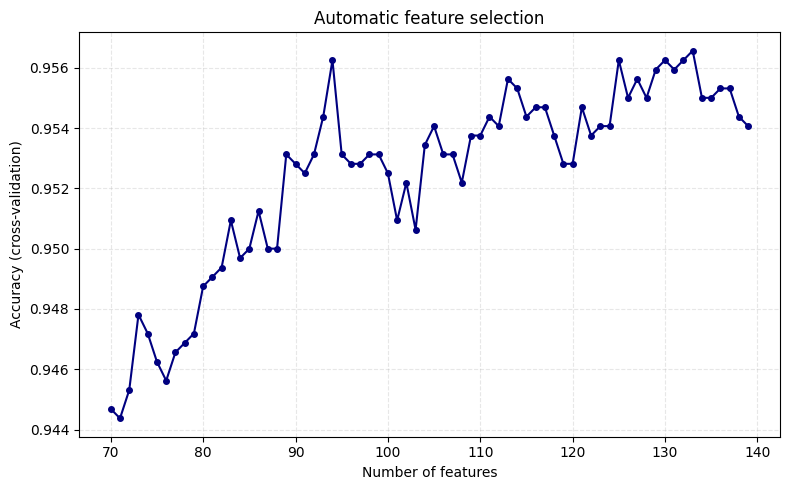

✅ Mejor número de features: 133, Accuracy: 0.9566


In [6]:
# 1. Remove highly correlated features

def remove_correlated_features(df, threshold=0.9, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []

    # Keep only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])

    # Drop excluded columns if present
    numeric_df = numeric_df.drop(columns=exclude_cols, errors="ignore")

    # Absolute correlation matrix
    corr_matrix = numeric_df.corr().abs()

    # Upper triangle of the correlation matrix
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    # Identify columns to drop
    to_drop = [
        column for column in upper.columns
        if any(upper[column] > threshold)
    ]

    return df.drop(columns=to_drop, errors="ignore"), to_drop


# 1.1 Apply correlation-based filtering
X_corr_filtered, _ = remove_correlated_features(
    X_train,
    exclude_cols=["station_name"]
)

# 1.2 Remove any remaining non-numeric columns (e.g. dates)
non_numeric_cols = X_corr_filtered.select_dtypes(exclude=[np.number]).columns
print("❗️ Non-numeric columns removed before Random Forest:", list(non_numeric_cols))
X_corr_filtered = X_corr_filtered.drop(columns=non_numeric_cols)


# 2. Random Forest to estimate feature importance

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42
)

X_rf = X_corr_filtered.copy()

# Encode station_name if present
if "station_name" in X_train.columns:
    X_rf["station_name"] = (
        X_train["station_name"].astype("category").cat.codes
    )

rf.fit(X_rf, y_train)

feature_importances = pd.Series(
    rf.feature_importances_,
    index=X_rf.columns
).sort_values(ascending=False)


# 3. Evaluate different numbers of top-ranked features

k_list = list(range(70, min(140, len(feature_importances) + 1)))
scores = []

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

for k in k_list:
    selected_features = feature_importances.head(k).index.tolist()

    # Ensure key demographic/technical variables are included if available
    for col in ["sex", "edad", "station_name"]:
        if col in X_train.columns and col not in selected_features:
            selected_features.append(col)

    X_train_k = X_train[selected_features]

    # Identify categorical and numeric columns
    categorical_cols = [
        col for col in ["sex", "station_name"]
        if col in X_train_k.columns
    ]
    numeric_cols = [
        col for col in X_train_k.columns
        if col not in categorical_cols
    ]

    # Preprocessing + classifier pipeline
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(drop="first"), categorical_cols),
    ])

    model = Pipeline([
        ("preproc", preprocessor),
        ("clf", LogisticRegression(max_iter=1000, random_state=42)),
    ])

    score = cross_val_score(
        model,
        X_train_k,
        y_train,
        cv=cv,
        scoring="accuracy"
    ).mean()

    scores.append(score)


# 4. Plot cross-validated performance as a function of k

plt.figure(figsize=(8, 5))
plt.plot(k_list, scores, marker="o", markersize=4, color="navy")
plt.xlabel("Number of features")
plt.ylabel("Accuracy (cross-validation)")
plt.title("Automatic feature selection")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()

plt.savefig("feature_selection_accuracy.png", dpi=300)
plt.show()


# 5. Select the optimal number of features

best_k = k_list[np.argmax(scores)]
print(f"Best number of features: {best_k}, Accuracy: {max(scores):.4f}")


# 6. Apply final feature selection

top_features_rf = feature_importances.head(best_k).index.tolist()
final_features = top_features_rf.copy()

for col in ["sex", "edad", "station_name"]:
    if col in X_train.columns and col not in final_features:
        final_features.append(col)

X_train_sel = X_train[final_features]
X_test_sel  = X_test[final_features]


# 7. Define final categorical and numeric columns

categorical_cols = [
    col for col in ["sex", "station_name"]
    if col in X_train_sel.columns
]
numeric_cols = [
    col for col in X_train_sel.columns
    if col not in categorical_cols
]


# 8. Final preprocessing transformer (reusable downstream)
preprocessor_1 = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(drop="first"), categorical_cols),
])

joblib.dump(final_features, "final_features.pkl")

### **5. PCA-based Dimensionality Reduction**

In [8]:
# Keep only numeric columns (e.g., remove dates or non-encodable strings)
X_train_clean = X_train.select_dtypes(include=[np.number]).copy()
X_test_clean  = X_test.select_dtypes(include=[np.number]).copy()

# Identify categorical columns that should be preserved
categorical_cols_all = []
for col in ["sex", "station_name"]:
    if col in X_train.columns:
        categorical_cols_all.append(col)

# Add categorical columns back to the cleaned datasets
for col in categorical_cols_all:
    X_train_clean[col] = X_train[col]
    X_test_clean[col]  = X_test[col]

# Define numeric columns (everything except categoricals)
numeric_cols_all = [c for c in X_train_clean.columns if c not in categorical_cols_all]

# Full preprocessing: scaling for numeric + one-hot encoding for categoricals
preprocessor_2 = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_cols_all),
    ("cat", OneHotEncoder(drop="first"), categorical_cols_all),
])

# Apply preprocessing
X_train_processed = preprocessor_2.fit_transform(X_train_clean)
X_test_processed  = preprocessor_2.transform(X_test_clean)

# Apply PCA (retain 95% cumulative explained variance)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca  = pca.transform(X_test_processed)

# Report PCA summary (keep the original print format)
print(f"[PCA] ✅ Número de componentes retenidos: {pca.n_components_}")
print(f"[PCA] ✅ Varianza explicada acumulada: {np.sum(pca.explained_variance_ratio_):.4f}")


[PCA] ✅ Número de componentes retenidos: 357
[PCA] ✅ Varianza explicada acumulada: 0.9503


### **6. Choice of dimensionality reduction strategy**

In [9]:
# Train and evaluate model – Path 1 (Random Forest feature selection)

pipeline_1 = Pipeline(steps=[
    ("preprocessor", preprocessor_1),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42)),
])

pipeline_1.fit(X_train_sel, y_train)

y_pred_1 = pipeline_1.predict(X_test_sel)
y_prob_1 = pipeline_1.predict_proba(X_test_sel)[:, 1]


# Train and evaluate model – Path 2 (PCA-based dimensionality reduction)

clf_pca = LogisticRegression(max_iter=1000, random_state=42)
clf_pca.fit(X_train_pca, y_train)

y_pred_2 = clf_pca.predict(X_test_pca)
y_prob_2 = clf_pca.predict_proba(X_test_pca)[:, 1]


# Evaluation metrics

def evaluate_model(y_true, y_pred, y_prob, name=""):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)

    print(f"\n=== {name} ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc,
        "conf_matrix": confusion_matrix(y_true, y_pred),
    }

# Results

results_models = {}

results_models["Ruta 1 - Selección con RF"] = evaluate_model(
    y_test,
    y_pred_1,
    y_prob_1,
    name="Ruta 1 - Selección con RF",
)

results_models["Ruta 2 - PCA"] = evaluate_model(
    y_test,
    y_pred_2,
    y_prob_2,
    name="Ruta 2 - PCA",
)



=== Ruta 1 - Selección con RF ===
Accuracy:  0.9600
Precision: 0.9767
Recall:    0.9426
F1-Score:  0.9594
ROC AUC:   0.9858

=== Ruta 2 - PCA ===
Accuracy:  0.9500
Precision: 0.9640
Recall:    0.9352
F1-Score:  0.9494
ROC AUC:   0.9826


### **7. Final dataset selection**

In [12]:
print("\n=== DECISIÓN FINAL ===")

if pca.n_components_ > 70:
    print(f"Ruta 1 es preferible: PCA generó {pca.n_components_} componentes (>70)")
    metodo_final = "Ruta 1"

elif res_ruta2["f1"] >= res_ruta1["f1"]:
    print(
        f"Ruta 2 es preferible: PCA generó {pca.n_components_} componentes con mejor o igual F1-score"
    )
    metodo_final = "Ruta 2"

else:
    print(
        f"Ruta 1 es preferible: Mejor F1-score aunque PCA generó menos de 70 componentes"
    )
    metodo_final = "Ruta 1"

print(f"\n>>> Método seleccionado: {metodo_final}")

# If PCA-based route is selected, overwrite the final train/test matrices
if metodo_final != "Ruta 1":
    X_train_sel, X_test_sel = X_train_pca, X_test_pca



=== DECISIÓN FINAL ===
Ruta 1 es preferible: PCA generó 357 componentes (>70)

>>> Método seleccionado: Ruta 1


### **8. Training and Tuning Classic ML models**

In [15]:
# Cross-validation strategy (fixed seed for reproducibility)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model definitions and hyperparameter grids
model_params = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "C": [0.001, 0.01, 0.1, 1, 10, 100],
            "penalty": ["l1", "l2"],
            "solver": ["liblinear", "saga"],
        },
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": list(range(1, 21)),
            "weights": ["uniform", "distance"],
            "p": [1, 2],
        },
    },
    "Support Vector Machine": {
        "model": SVC(probability=True),
        "params": {
            "C": [0.01, 0.1, 1, 10, 100],
            "kernel": ["linear", "rbf", "sigmoid", "poly"],
            "gamma": ["scale", "auto"],
        },
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [None, 5, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4, 6],
            "criterion": ["gini", "entropy"],
            "max_features": [None, "sqrt", "log2"],
        },
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "max_features": ["sqrt", "log2", None],
            "bootstrap": [True, False],
        },
    },
}

# Output directory (kept for reproducibility / optional reuse)
os.makedirs("modelos_clasicos", exist_ok=True)

trained_models = {}
best_scores = {}
best_estimators = {}
results_rows = []

print(f"\n🧪 Usando X_train_sel con forma: {X_train_sel.shape}")

for name, mp in model_params.items():
    print(f"\n🔍 Entrenando y optimizando {name}...")

    # Pipeline with the classifier only (preprocessing was applied upstream)
    pipeline = Pipeline(steps=[
        ("classifier", mp["model"])
    ])

    # GridSearchCV parameter names must match pipeline step prefix
    param_grid = {f"classifier__{k}": v for k, v in mp["params"].items()}

    start = time.time()
    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=skf,
        scoring="roc_auc",
        n_jobs=-1
    )
    grid.fit(X_train_sel, y_train)
    duration = round(time.time() - start, 2)

    # Store best estimators and CV scores
    best_estimators[name] = grid.best_estimator_
    trained_models[name] = grid.best_estimator_
    best_scores[name] = grid.best_score_

    # Prints intentionally kept identical (including emojis)
    print(f"✅ Mejores parámetros: {grid.best_params_}")
    print(f"✅ Mejor AUC (CV): {grid.best_score_:.4f}")
    print(f"⏱️  Tiempo de entrenamiento: {duration} segundos")

    # Append to summary table
    results_rows.append({
        "modelo": name,
        "mejor_auc_cv": round(grid.best_score_, 4),
        "mejores_params": json.dumps(grid.best_params_),
        "tiempo_segundos": duration,
    })

    # Persist best estimator (timestamped)
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    filename = f"modelos_clasicos/{name.replace(' ', '_')}_{timestamp}.pkl"
    joblib.dump(grid.best_estimator_, filename)

# Save global results table
df_resultados = pd.DataFrame(results_rows)
csv_timestamp = time.strftime("%Y%m%d_%H%M%S")
csv_name = f"classic_ML_models_validation_results_{csv_timestamp}.csv"
df_resultados.to_csv(csv_name, index=False)

print(f"\n📄 Resultados guardados en: {csv_name}")



🧪 Usando X_train_sel con forma: (3200, 134)

🔍 Entrenando y optimizando Logistic Regression...


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:34

✅ Mejores parámetros: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
✅ Mejor AUC (CV): 0.9928
⏱️  Tiempo de entrenamiento: 31.93 segundos

🔍 Entrenando y optimizando K-Nearest Neighbors...
✅ Mejores parámetros: {'classifier__n_neighbors': 20, 'classifier__p': 2, 'classifier__weights': 'uniform'}
✅ Mejor AUC (CV): 0.9832
⏱️  Tiempo de entrenamiento: 5.55 segundos

🔍 Entrenando y optimizando Support Vector Machine...
✅ Mejores parámetros: {'classifier__C': 0.01, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
✅ Mejor AUC (CV): 0.9923
⏱️  Tiempo de entrenamiento: 458.91 segundos

🔍 Entrenando y optimizando Decision Tree...
✅ Mejores parámetros: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__max_features': None, 'classifier__min_samples_leaf': 6, 'classifier__min_samples_split': 10}
✅ Mejor AUC (CV): 0.9071
⏱️  Tiempo de entrenamiento: 25.08 segundos

🔍 Entrenando y optimizando Random Forest...
✅ Mejores parám

### **9. Comparative metrics table by AUC**

In [23]:
csv_metricas_final = os.path.join(output_dir, f"classic_ML_full_metrics_{timestamp}.csv")
tabla_metricas = []

for name, model in trained_models.items():
    try:
        y_pred = model.predict(X_test_sel)

        # Usar probabilidades si se puede
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test_sel)[:, 1]
        elif hasattr(model, "decision_function"):
            y_proba = model.decision_function(X_test_sel)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
        else:
            y_proba = None

        # Confusion matrix
        tn, fp, fn, tp =# Output CSV path (kept consistent with previous blocks)
csv_metricas_final = os.path.join(output_dir, f"classic_ML_full_metrics_{timestamp}.csv")

metrics_rows = []

for name, model in trained_models.items():
    try:
        # Class predictions
        y_pred = model.predict(X_test_sel)

        # Probability scores (preferred) or calibrated decision function (fallback)
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test_sel)[:, 1]
        elif hasattr(model, "decision_function"):
            y_proba = model.decision_function(X_test_sel)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
        else:
            y_proba = None

        # Confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        # Metrics (threshold fixed at 0.5)
        recall = recall_score(y_test, y_pred)
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = precision_score(y_test, y_pred)
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

        metrics_rows.append({
            "modelo": name,
            "cut_off": 0.5,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp,
            "sensibilidad": round(recall, 3),
            "especificidad": round(specificity, 3),
            "ppv": round(precision, 3),
            "npv": round(npv, 3),
            "accuracy": round(accuracy, 3),
            "f1": round(f1, 3),
            "auc": round(auc, 3) if auc is not None else None,
        })

    except Exception as e:
        print(f"[{name}] Error en evaluación: {e}")

# Save full metrics table
df_metricas = pd.DataFrame(metrics_rows)
df_metricas.to_csv(csv_metricas_final, index=False)

# Display TOP-3 models by AUC (printed output intentionally kept unchanged)
top_3_models = df_metricas.sort_values(by="auc", ascending=False).head(3)

print("\n=== TOP 3 MODELOS POR AUC ===")
print(top_3_models.to_string(index=False))
print(f"\n✅ Métricas guardadas en: {csv_metricas_final}")
 confusion_matrix(y_test, y_pred).ravel()

        # Metrics
        recall = recall_score(y_test, y_pred)
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = precision_score(y_test, y_pred)
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

        tabla_metricas.append({
            "modelo": name,
            "cut_off": 0.5,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp,
            "sensibilidad": round(recall, 3),
            "especificidad": round(specificity, 3),
            "ppv": round(precision, 3),
            "npv": round(npv, 3),
            "accuracy": round(accuracy, 3),
            "f1": round(f1, 3),
            "auc": round(auc, 3)
        })

    except Exception as e:
        print(f"[{name}] Error en evaluación: {e}")

# Save CSV 
df_metricas = pd.DataFrame(tabla_metricas)
df_metricas.to_csv(csv_metricas_final, index=False)

# Show top 3 by AUC
top_3_models = df_metricas.sort_values(by="auc", ascending=False).head(3)

print("\n=== TOP 3 MODELOS POR AUC ===")
print(top_3_models.to_string(index=False))
print(f"\n✅ Métricas guardadas en: {csv_metricas_final}")



=== TOP 3 MODELOS POR AUC ===
                modelo     cut_off  tn  fp  fn  tp  sensibilidad  especificidad         ppv         npv    accuracy          f1         auc
Support Vector Machine 0.500000000 390   9  21 380   0.948000000    0.977000000 0.977000000 0.949000000 0.963000000 0.962000000 0.987000000
   Logistic Regression 0.500000000 390   9  24 377   0.940000000    0.977000000 0.977000000 0.942000000 0.959000000 0.958000000 0.986000000
   K-Nearest Neighbors 0.500000000 392   7  56 345   0.860000000    0.982000000 0.980000000 0.875000000 0.921000000 0.916000000 0.979000000

✅ Métricas guardadas en: comparative_model_results/classic_ML_full_metrics_20250722_090340.csv


In [25]:
best_model_name = top_3_models.iloc[0]["modelo"]
best_model = trained_models[best_model_name]

X_full = pd.concat([X_train_sel, X_test_sel])
y_full = pd.concat([y_train, y_test])

In [28]:
# Save the best model
joblib.dump(best_model_final, f"mejor_modelo.pkl")
print(f"Modelo guardado como: mejor_modelo.pkl")

Modelo guardado como: mejor_modelo.pkl


### **10. Feature Importance Analysis**

In [29]:
# This analysis is only applicable to models that expose
# the `feature_importances_` attribute (e.g. Random Forest)

if hasattr(best_model.named_steps["classifier"], "feature_importances_"):
    importances = best_estimator.feature_importances_
    indices = np.argsort(importances)[-10:][::-1]

    plt.figure(figsize=(10, 6))
    plt.bar(range(10), importances[indices])
    plt.xticks(range(10), X.columns[indices], rotation=90)
    plt.title(f'Top 10 Variables Más Importantes ({best_model_name})')
    plt.tight_layout()
    plt.show()
else:
    print(f"El modelo {best_model_name} no proporciona importancia de variables directamente.")


El modelo Support Vector Machine no proporciona importancia de variables directamente.


### **11. Summary and Conclusions**

In this notebook we trained and optimised several classical machine learning classifiers on top of CNN-extracted image features, using stratified cross-validation and ROC AUC as the main selection criterion. Across logistic regression, k-nearest neighbours, support vector machine, decision tree and random forest, the best-performing models reached very high discriminative performance on the internal validation folds.

The hyperparameter-tuned estimators were then evaluated on the held-out internal test set, allowing us to obtain a consistent set of metrics (confusion matrix, sensitivity, specificity, PPV, NPV, F1 score, accuracy and AUC) and to identify the single best hybrid model for subsequent comparison. All trained models and their performance summaries were saved to disk to ensure full reproducibility.

The comparative analysis between this best classical ML model and the end-to-end CNN, including joint ROC plots and statistical comparison of AUCs (e.g. DeLong’s test), is deliberately performed in a dedicated evaluation notebook. This separation keeps the present document focused on the training and optimisation pipeline, while the downstream clinical and statistical interpretation is handled in the corresponding evaluation workflow.
